# Coffea-Casa Processor-Based Workflow Test

This notebook demonstrates the UnifiedProcessor workflow with coffea.processor.Runner on Coffea-Casa, including skimming, analysis, histogramming, and statistics steps.

## Workflow Overview

1. Setup Python path for intccms package
2. Install dependencies and register modules for cloud pickle
3. Acquire Dask client from Coffea-Casa environment
4. Configure analysis parameters
5. Run metadata extraction
6. Initialize UnifiedProcessor
7. Run processor with coffea.processor.Runner
8. Save histograms
9. Run statistical analysis (if enabled)

In [1]:
# Setup Python path to include intccms package
import sys
import time
from pathlib import Path

# Add src directory to Python path
repo_root = Path.cwd()
src_dir = repo_root / "src"
examples_dir = repo_root
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))
if str(examples_dir) not in sys.path:
    sys.path.insert(0, str(examples_dir))
print(f"✅ Added {src_dir} to Python path")
print(f"✅ Added {examples_dir} to Python path")

✅ Added /home/cms-jovyan/intc/integration-challenge/cms/src to Python path
✅ Added /home/cms-jovyan/intc/integration-challenge/cms to Python path


In [2]:
COFFEA_VERSION = "git+https://github.com/MoAly98/coffea.git@feat/fobj_in_procmeta" #"2025.11.0"
COFFEA_PIP = f"coffea=={COFFEA_VERSION}" if "git" not in COFFEA_VERSION else COFFEA_VERSION
try:
    import omegaconf
except ImportError:
    print("⚠️ omegaconf not found, installing...")
    ! pip install omegaconf

! pip install $COFFEA_PIP

  Cloning https://github.com/MoAly98/coffea.git (to revision feat/fobj_in_procmeta) to /tmp/pip-req-build-20phy1mp
  Running command git clone --filter=blob:none --quiet https://github.com/MoAly98/coffea.git /tmp/pip-req-build-20phy1mp
  Running command git checkout -b feat/fobj_in_procmeta --track origin/feat/fobj_in_procmeta
  Switched to a new branch 'feat/fobj_in_procmeta'
  branch 'feat/fobj_in_procmeta' set up to track 'origin/feat/fobj_in_procmeta'.
  Resolved https://github.com/MoAly98/coffea.git to commit 4d31551ef080bfe97eb54eb29f43b5f39727dec9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# Imports and cloudpickle registration
import copy
import os

os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""

from dask.distributed import Client, PipInstall
from coffea.processor import DaskExecutor, IterativeExecutor
from coffea.nanoevents import NanoAODSchema

import cloudpickle
import intccms
import example_cms
import roastcoffea

# Register modules for cloud pickle
cloudpickle.register_pickle_by_value(intccms)
cloudpickle.register_pickle_by_value(example_cms)
cloudpickle.register_pickle_by_value(roastcoffea)

from example_cms.configs.configuration import config as original_config
from intccms.schema import Config, load_config_with_restricted_cli
from intccms.utils.output import OutputDirectoryManager
from intccms.metadata_extractor import DatasetMetadataManager
from intccms.datasets import DatasetManager
from intccms.analysis import run_processor_workflow

## Acquire Dask Client

Coffea-Casa provides a shared scheduler. Connect to it and register dependencies.

In [4]:
from dask.distributed import WorkerPlugin
from contextlib import contextmanager

class RedirectStderrToStdout(WorkerPlugin):
    def setup(self, worker):
        # crude but effective: route stderr to stdout
        sys.stderr = sys.stdout

@contextmanager
def acquire_client(af="gateway"):
    """Context manager to acquire and safely close a Dask client from a Coffea-Casa environment."""
    dependencies = [COFFEA_PIP, "git+https://github.com/MoAly98/roastcoffea.git"]
    client = None
    cluster = None
    try:
        if af == "condor":
            client = Client("tls://localhost:8786")
            client.register_plugin(PipInstall(packages=dependencies))
            client.forward_logging()
            cluster = None

        elif af == "gateway":
            def set_env(dask_worker):
                config_path = str(Path(dask_worker.local_directory) / 'access_token')
                os.environ["BEARER_TOKEN_FILE"] = config_path
                os.chmod(config_path, 0o600)
                os.chmod("/etc/grid-security/certificates", 0o755)

            num_workers = 350   #number of workers desired
            from dask_gateway import Gateway
            gateway = Gateway()
            clusters = gateway.list_clusters()
            cluster = gateway.connect(clusters[0].name)
            client = cluster.get_client()
            cluster.scale(num_workers)
            client.wait_for_workers(num_workers)
            client.upload_file("/etc/cmsaf-secrets-chown/access_token")
            client.register_worker_callbacks(setup=set_env)
            client.register_plugin(PipInstall(packages=dependencies))
            client.register_plugin(RedirectStderrToStdout(), name="redirect-stderr")

        print(f"✅ Connected to Dask scheduler")
        print(f"📊 Dashboard: {client.dashboard_link}")

        yield client, cluster
    except Exception as e:
        print(e)
    finally:
        if client is not None:
            client.close()
            print("✅ Client closed")

## Configuration Setup

Configure analysis parameters including which processes to run and output settings.

In [5]:
# Configuration setup
config = copy.deepcopy(original_config)

# Limit files for testing
config["datasets"]["max_files"] = 10

# Use local output directory
config["general"]["output_dir"] = "example_cms/outputs/"

# Configuration flags
config["general"]["read_from_cache"] = False
config["general"]["run_metadata_generation"] = False
config["general"]["run_processor"] = True  # Set to False to skip processor and load saved histograms
config["general"]["save_skimmed_output"] = False  # Set to True to save filtered events to disk
config["general"]["run_analysis"] = True
config["general"]["run_histogramming"] = True
config["general"]["run_systematics"] = True
config["general"]["run_statistics"] = False

# Test only signal dataset
#config["general"]["processes"] = ["data"]

cli_args = []
full_config = load_config_with_restricted_cli(config, cli_args)
validated_config = Config(**full_config)

## Run Complete Workflow

Execute the full processor workflow with proper cleanup in a try/finally block.

In [6]:
# Set up output manager
output_manager = OutputDirectoryManager(
    root_output_dir=validated_config.general.output_dir,
    cache_dir=validated_config.general.cache_dir,
    metadata_dir=validated_config.general.metadata_dir,
    skimmed_dir=validated_config.general.skimmed_dir
)
print(f"✅ Output directory: {output_manager.root_output_dir}")

11:24:50 INFO     Output directory manager initialized with root:                                ]8;id=471125;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/directories.py\directories.py]8;;\:]8;id=42438;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/directories.py#169\169]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs                              

✅ Output directory: /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs


In [7]:
# Set up dataset manager
dataset_manager = DatasetManager(validated_config.datasets)

         INFO     Initialized dataset manager with 10 datasets                                        ]8;id=5837;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/datasets/manager.py\manager.py]8;;\:]8;id=239575;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/datasets/manager.py#34\34]8;;\

In [8]:
# Extract metadata using Dask client
with acquire_client(af="condor") as (client, cluster):
    metadata_generator = DatasetMetadataManager(
        dataset_manager=dataset_manager,
        output_manager=output_manager,
        executor=DaskExecutor(client=client),
        config=validated_config,
    )
    metadata_generator.run( # TODO:: No need for these args
        generate_metadata=validated_config.general.run_metadata_generation, 
        processes_filter=validated_config.general.processes if hasattr(validated_config.general, 'processes') else None
    )

✅ Connected to Dask scheduler
📊 Dashboard: /user/mohamed.aly@cern.ch/proxy/8787/status


11:25:43 INFO     Initialized DatasetMetadataManager with output dir:                                ]8;id=57509;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=221278;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#131\131]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/metadata                     

         INFO     Loading existing metadata from:                                                    ]8;id=826665;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=891787;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#221\221]8;;\
                  {                                                                                                
                      'fileset_path':                                                                              
                  PosixPath('/home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/met               
                  adata/fileset.json'),                                                                            
                      'workitems_path':                                                                            
                  PosixPath('/home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/met               
                  adata/workitems.json'),                                                                          
                      'nanoaods_summary_path':                                                                     
                  PosixPath('/home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/met               
                  adata/nanoaods.json')                                                                            
                  }                                                                                                

         INFO     Loaded 10 Dataset objects from fileset                                             ]8;id=346244;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=204224;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#326\326]8;;\

         INFO     Loaded 4348 WorkItems                                                              ]8;id=697170;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=455686;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#333\333]8;;\

         INFO     Loaded event count summary                                                         ]8;id=938044;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=263653;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#339\339]8;;\

         INFO     All metadata successfully loaded from disk.                                        ]8;id=255568;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=337746;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#229\229]8;;\

✅ Client closed


In [9]:
# Build metadata lookup and extract workitems
metadata_lookup = metadata_generator.build_metadata_lookup()
workitems = metadata_generator.workitems
print(f"Generated {len(workitems)} workitems...")

         INFO     Built metadata lookup for 125 fileset keys                                         ]8;id=261297;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=479158;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#427\427]8;;\

Generated 4348 workitems...


In [10]:
# Run processor workflow with roastcoffea metrics collection
from roastcoffea import MetricsCollector
from intccms.analysis.processor import UnifiedProcessor

with acquire_client(af="condor") as (client, cluster):
    # Create processor instance for MetricsCollector
    unified_processor = UnifiedProcessor(
        config=validated_config,
        output_manager=output_manager,
        metadata_lookup=metadata_lookup,
    )

    # Wrap workflow in MetricsCollector for comprehensive metrics
    with MetricsCollector(
        client=client,
        processor_instance=unified_processor,
        track_workers=True,
        worker_tracking_interval=1.0,
    ) as collector:
        t0 = time.perf_counter()
        output, report = run_processor_workflow(
            config=validated_config,
            output_manager=output_manager,
            metadata_lookup=metadata_lookup,
            workitems=workitems,
            executor=DaskExecutor(client=client, treereduction=8, retries=0),
            schema=NanoAODSchema,
        )
        t1 = time.perf_counter()

        # Extract chunk metrics from output (injected by @track_metrics decorator)
        collector.extract_metrics_from_output(output)

        # Set coffea report for aggregation
        collector.set_coffea_report(report)

    # Get aggregated metrics after context exits
    metrics = collector.get_metrics()
    tracking_data = collector.tracking_data
    span_metrics = getattr(collector, 'span_metrics', None)

print(f"✅ Processor workflow complete in {t1-t0:.1f} seconds!")

# Print summary
if validated_config.general.run_processor:
    print(f"📊 Total events processed: {output.get('processed_events', 0):,}")
    if 'skimmed_events' in output:
        print(f"✂️  Events after skim: {output.get('skimmed_events', 0):,}")

✅ Connected to Dask scheduler
📊 Dashboard: /user/mohamed.aly@cern.ch/proxy/8787/status


11:26:37 INFO     Initialized UnifiedProcessor: save_skimmed_output=False, analysis=True,          ]8;id=870617;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=697824;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#195\195]8;;\
                  histogramming=True, systematics=True                                                             

         INFO     Running processor over data...                                                      ]8;id=735085;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=449520;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py#109\109]8;;\

         INFO     Initialized UnifiedProcessor: save_skimmed_output=False, analysis=True,          ]8;id=319198;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=526485;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#195\195]8;;\
                  histogramming=True, systematics=True                                                             

         INFO     Processing 4348 work items with chunksize=200000                                    ]8;id=694760;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=368063;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py#199\199]8;;\

Output()

11:27:08 WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=664042;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=521913;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=961409;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=880830;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=560357;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=219414;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=763891;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=565574;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=455659;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=437223;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=63214;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=165190;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=672622;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=453164;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=673163;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=435288;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=552307;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=685371;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=867130;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=997657;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=396494;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=734773;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=386431;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=618276;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=400765;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=101958;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=257610;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=787280;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=974246;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=61033;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=643870;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=457517;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=423212;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=246385;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=717772;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=238685;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=199524;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=211728;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

         WARNING  Matplotlib is building the font cache; this may take a moment.               ]8;id=773763;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=706202;file:///usr/local/lib/python3.12/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

11:30:02 INFO     Postprocessing complete: 794088713 total events                                  ]8;id=483734;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=410716;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#387\387]8;;\

         INFO     Histograms written to pickle:                                                    ]8;id=310529;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=205226;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py#45\45]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/histograms/p                 
                  rocessor_histograms.pkl                                                                          

         INFO     Saved processor histograms (pickle) to                                           ]8;id=761309;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=971180;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#399\399]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/histograms/p                 
                  rocessor_histograms.pkl                                                                          

         INFO     Filtered 8 invalid systematic variations from data samples                      ]8;id=587745;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=325325;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py#188\188]8;;\

         INFO     Histograms written to ROOT file:                                                ]8;id=791018;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=182605;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py#137\137]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/histograms/                  
                  histograms.root                                                                                  

         INFO     Saved processor histograms (ROOT) to                                             ]8;id=869409;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=928684;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#407\407]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/histograms/h                 
                  istograms.root                                                                                   

         INFO     Processor complete: 794,088,713 events processed, 30,703,728 events after skim      ]8;id=880122;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=173233;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py#205\205]8;;\

✅ Client closed
✅ Processor workflow complete in 205.3 seconds!
📊 Total events processed: 794,088,713
✂️  Events after skim: 30,703,728


## Performance Metrics (roastcoffea)

This section displays comprehensive performance metrics collected during the workflow execution using roastcoffea.

In [11]:
# Import roastcoffea reporting and visualization
from rich.console import Console
from roastcoffea.export.reporter import (
    format_throughput_table,
    format_event_processing_table,
    format_resources_table,
    format_timing_table,
    format_fine_metrics_table,
)

console = Console()

# Display metrics tables
if metrics:
    print("\n" + "=" * 60)
    print("📊 Processing Metrics")
    print("=" * 60)

    print("\n📈 Throughput Metrics")
    console.print(format_throughput_table(metrics))

    print("\n⚡ Event Processing Metrics")
    console.print(format_event_processing_table(metrics))

    print("\n🖥️  Resource Utilization")
    console.print(format_resources_table(metrics))

    print("\n⏱️  Timing Breakdown")
    console.print(format_timing_table(metrics))

    # Fine-grained metrics from Dask Spans (CPU/IO breakdown)
    fine_table = format_fine_metrics_table(metrics)
    if fine_table:
        print("\n🔬 Fine-Grained Metrics (CPU/IO Breakdown)")
        console.print(fine_table)
else:
    print("⚠️  Metrics collection was not enabled")


📊 Processing Metrics

📈 Throughput Metrics


                  Throughput Metrics                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric                    ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Data Rate                 │ 2.69 Gbps (336.8 MB/s) │
│ Total Bytes Read (Coffea) │ 64.41 GB               │
│ Memory Read (Dask Spans)  │ 1.60 GB                │
└───────────────────────────┴────────────────────────┘


⚡ Event Processing Metrics


            Event Processing Metrics            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃ Value           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Total Events               │ 794,088,713     │
│ Event Rate (Wall Clock)    │ 3867.8 kHz      │
│ Event Rate (Aggregated)    │ 48.0 kHz        │
│ Event Rate (Core-Averaged) │ 16115.7 Hz/core │
│ Efficiency Ratio           │ 8058.4%         │
└────────────────────────────┴─────────────────┘


🖥️  Resource Utilization


          Resource Utilization          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                   ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Workers (Time-Averaged)  │ 240.0     │
│ Peak Workers             │ 240       │
│ Cores per Worker         │ 1.0       │
│ Total Cores              │ 240       │
│ Core Efficiency          │ 33.6%     │
│ Speedup Factor           │ 80.6x     │
│ Peak Memory (per worker) │ 1.84 GB   │
│ Avg Memory (per worker)  │ 609.83 MB │
└──────────────────────────┴───────────┘


⏱️  Timing Breakdown


         Timing Breakdown          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric             ┃ Value      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Wall Time          │ 3m 25s     │
│ Total CPU Time     │ 4h 35m 44s │
│ Number of Chunks   │ 4,348      │
│ Avg CPU Time/Chunk │ 3.8s       │
└────────────────────┴────────────┘


🔬 Fine-Grained Metrics (CPU/IO Breakdown)


      Fine Metrics (from Dask Spans)       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric                     ┃ Value      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Processor CPU Time         │ 9h 43m 29s │
│ Processor Non-CPU Time     │ 2h 3m 12s  │
│   CPU %                    │ 82.6%      │
│   Non-CPU %                │ 17.4%      │
│ Dask Overhead CPU Time     │ 36.7s      │
│ Dask Overhead Non-CPU Time │ 4.0s       │
└────────────────────────────┴────────────┘

### Performance Visualizations

Timeline plots and efficiency summaries from roastcoffea metrics collection.


📊 Performance Visualizations

📊 Data Throughput Over Time


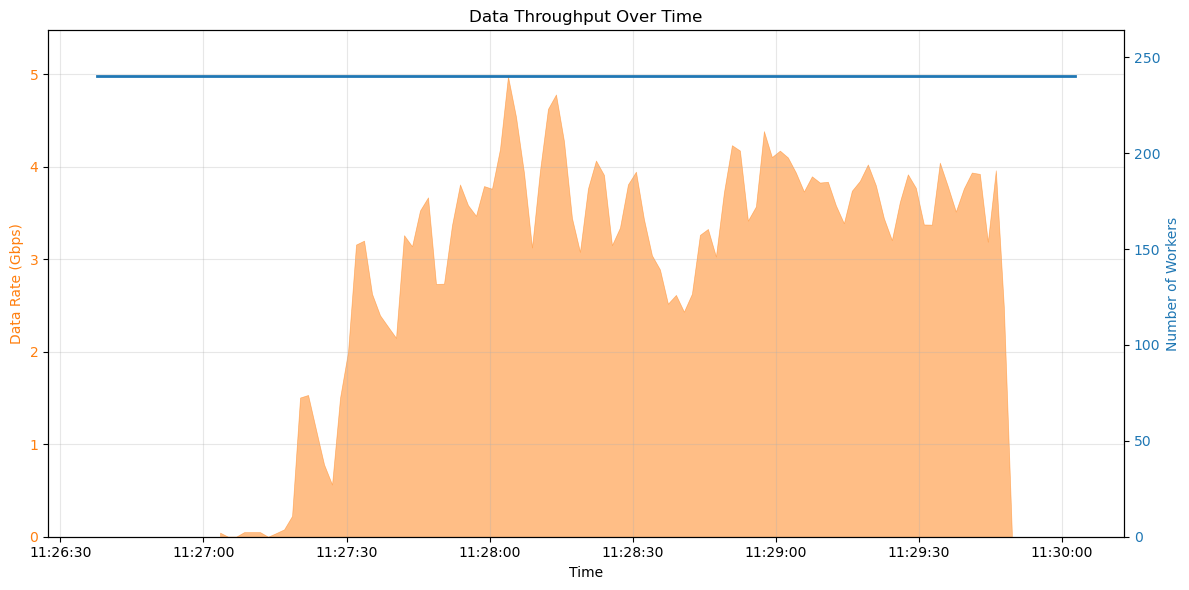


📊 Worker Count Over Time


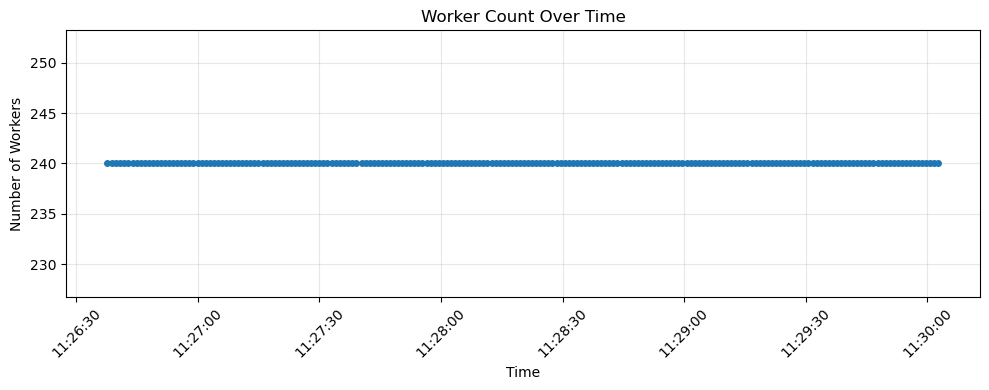


📊 Memory Utilization


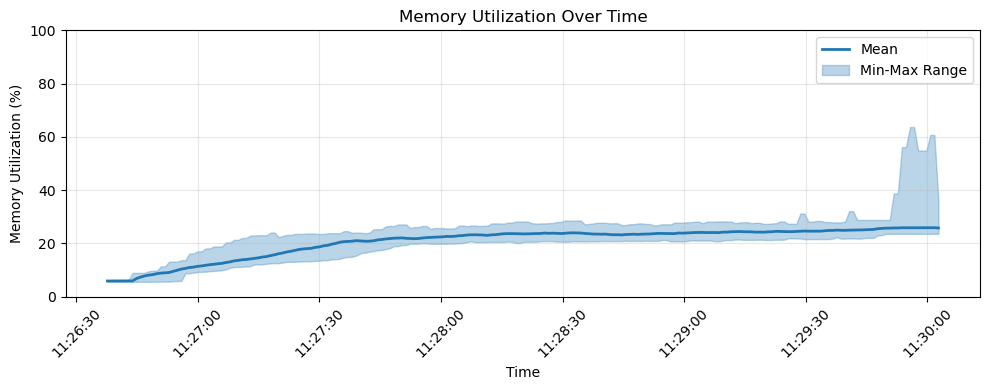


📊 Worker Occupancy


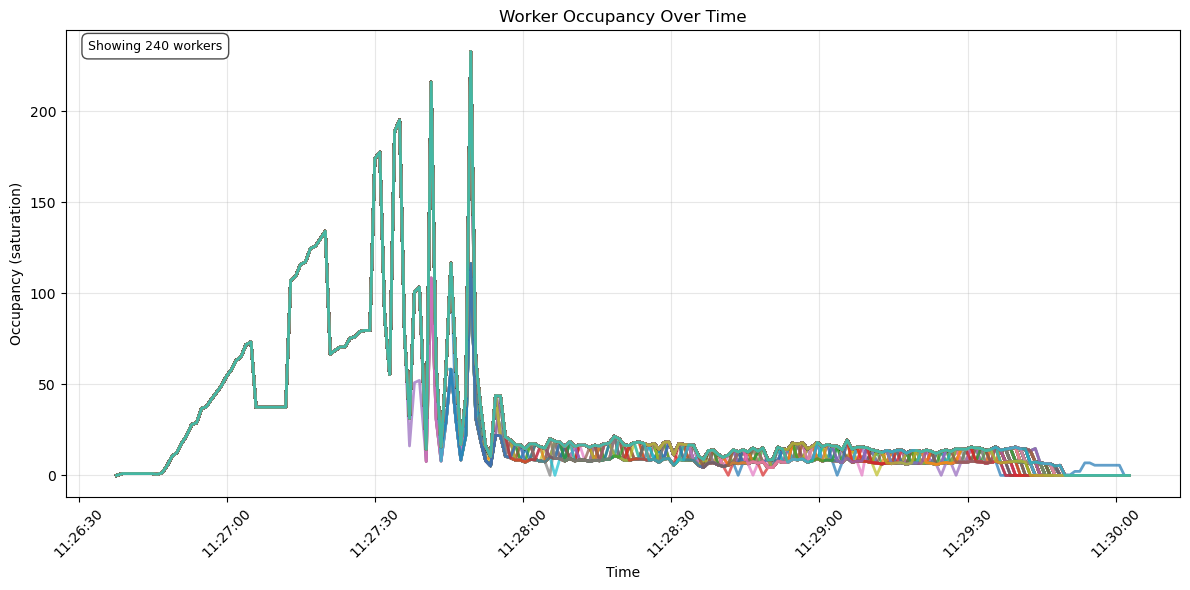


📊 Executing Tasks Per Worker


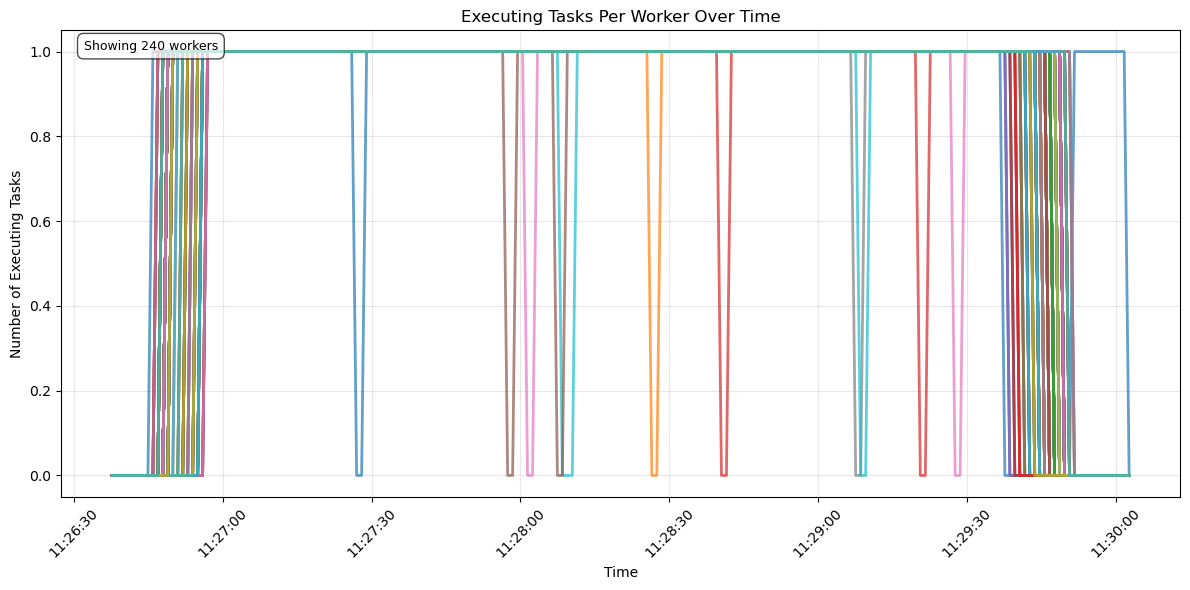


📊 Total Active Tasks


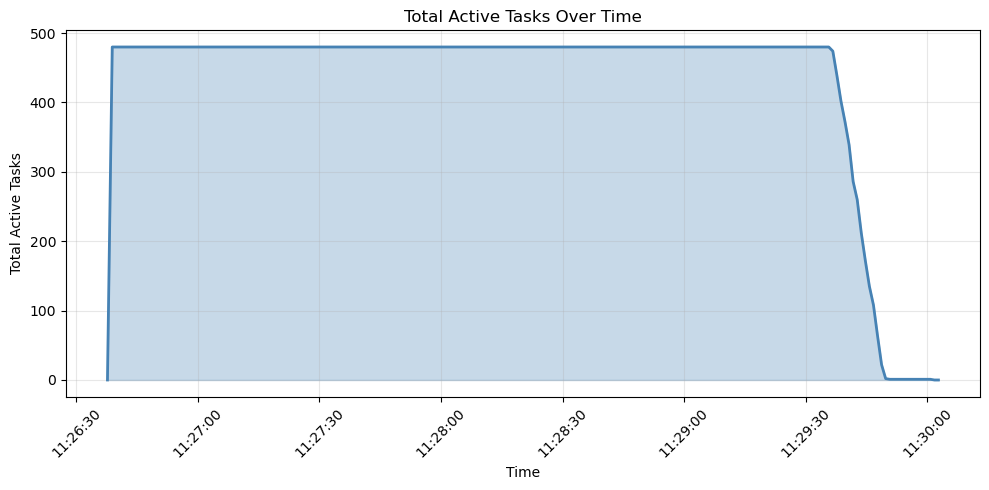


📊 Worker Activity Timeline


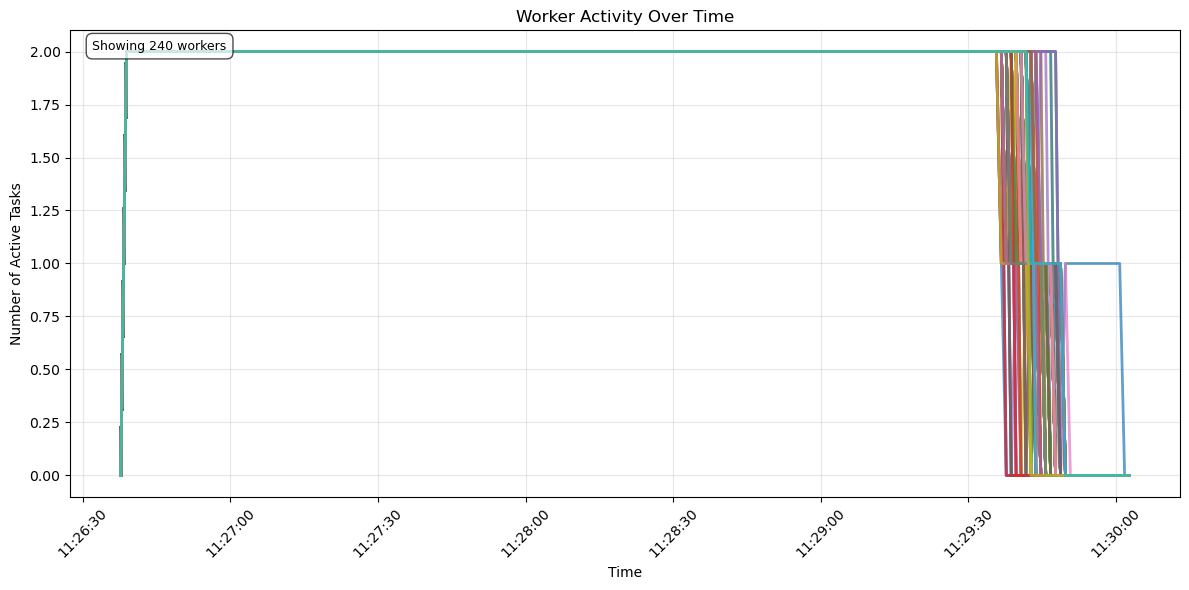


📊 Per-Task CPU vs I/O Breakdown


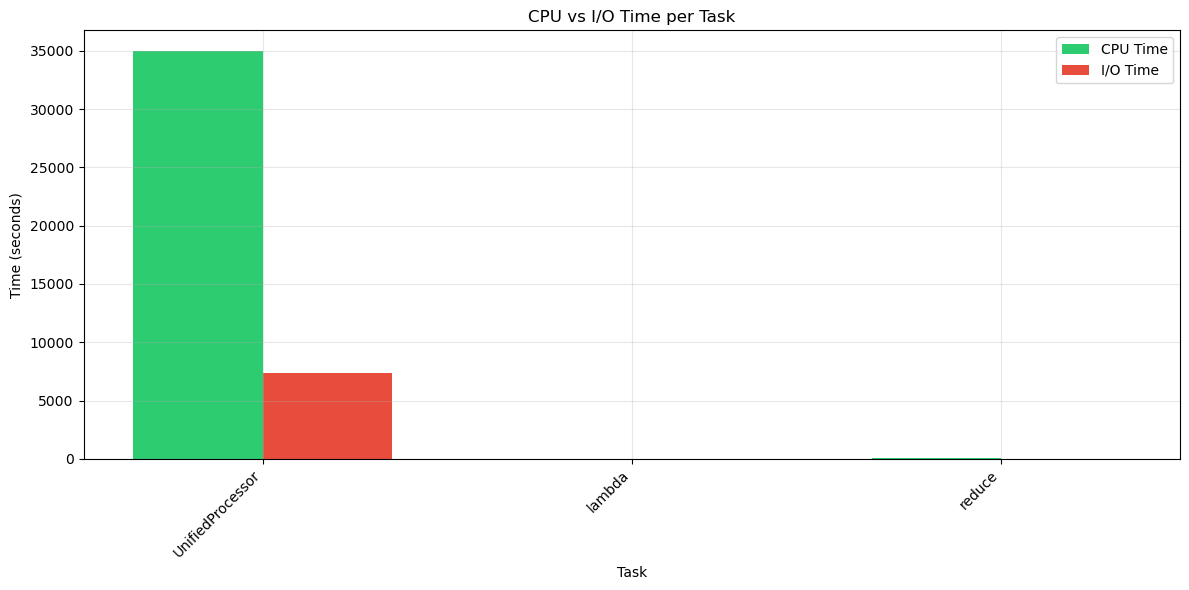


📊 Per-Task Bytes Read
⚠️  Bytes read plot unavailable: No per-task disk-read metrics found in span_metrics

📊 Per-Task Compression & Serialization Overhead
⚠️  Overhead plot unavailable: No per-task overhead metrics found in span_metrics

📊 Efficiency Summary


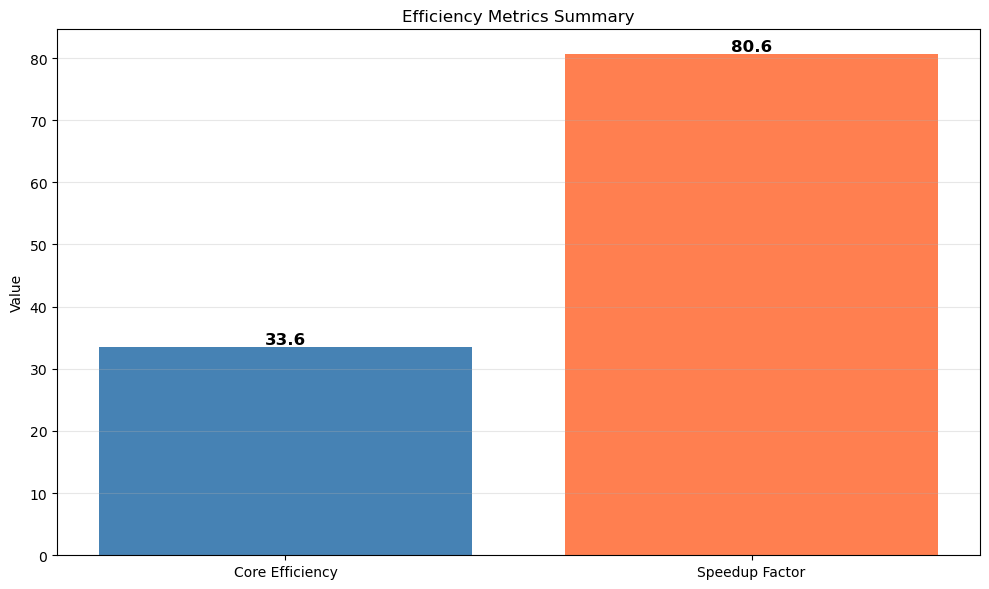


📊 Resource Utilization


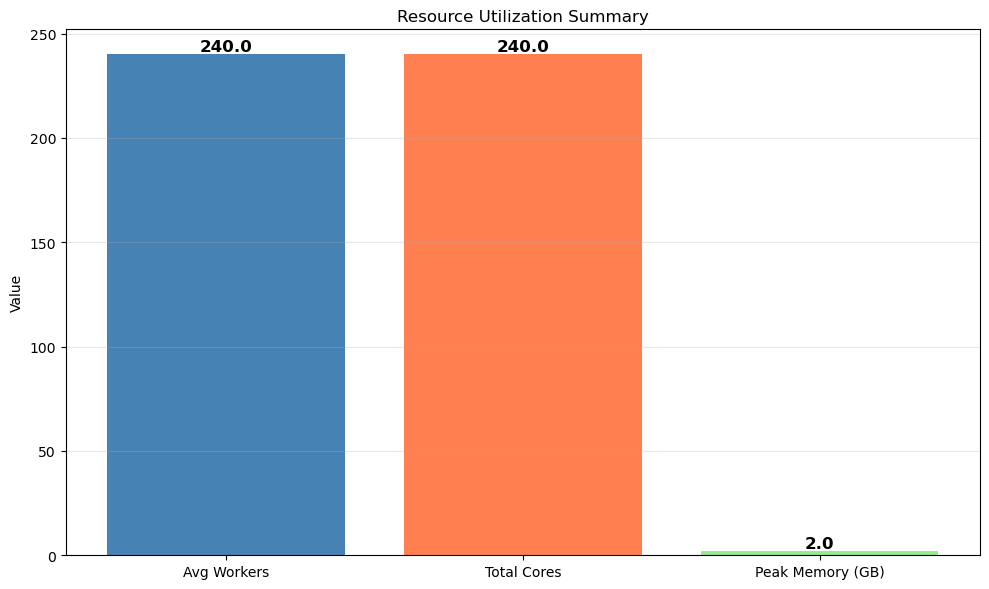

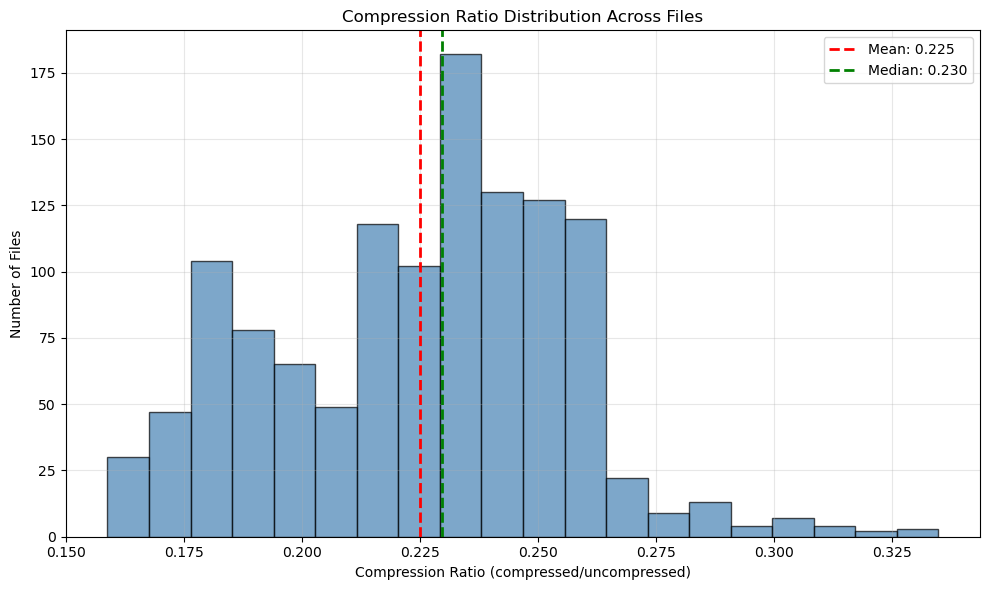

✅ Compression ratios show file compression efficiency


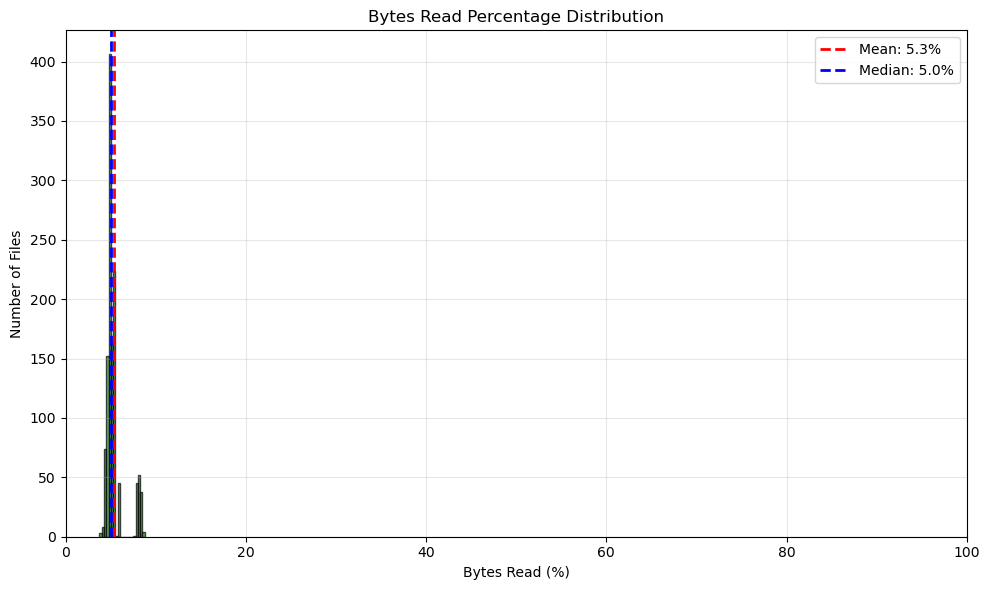

✅ Shows what % of each file's data was actually read


In [12]:
# Performance Visualizations
import matplotlib.pyplot as plt
from roastcoffea.visualization.plots import (
  plot_worker_count_timeline,
  plot_memory_utilization_timeline,
  plot_occupancy_timeline,
  plot_executing_tasks_timeline,
  plot_total_active_tasks_timeline,
  plot_worker_activity_timeline,
  plot_throughput_timeline,
  plot_per_task_cpu_io,
  plot_per_task_bytes_read,
  plot_per_task_overhead,
  plot_efficiency_summary,
  plot_resource_utilization,
  plot_compression_ratio_distribution,
  plot_data_access_percentage,
  plot_cpu_utilization_timeline,
  plot_runtime_distribution,
  plot_runtime_vs_events,
)

print("\n" + "=" * 60)
print("📊 Performance Visualizations")
print("=" * 60)

#print(metrics["chunk_info"])
# Data throughput over time (with worker count overlay)
if metrics and "chunk_info" in metrics:
  print("\n📊 Data Throughput Over Time")
  try:
      fig, ax = plot_throughput_timeline(metrics["chunk_info"], tracking_data)
      plt.show()
  except Exception as e:
      print(f"⚠️  Throughput plot unavailable: {e}")

# Worker count timeline
if tracking_data and "worker_counts" in tracking_data:
  print("\n📊 Worker Count Over Time")
  try:
      fig, ax = plot_worker_count_timeline(tracking_data)
      plt.show()
  except Exception as e:
      print(f"⚠️  Worker count plot unavailable: {e}")
else:
  print("⚠️  Worker count data not available")

# Memory utilization
if tracking_data and "worker_memory" in tracking_data:
  print("\n📊 Memory Utilization")
  try:
      fig, ax = plot_memory_utilization_timeline(tracking_data)
      plt.show()
  except Exception as e:
      print(f"⚠️  Memory plot unavailable: {e}")

# Worker occupancy (task saturation)
if tracking_data and "worker_occupancy" in tracking_data:
  print("\n📊 Worker Occupancy")
  try:
      fig, ax = plot_occupancy_timeline(tracking_data)
      plt.show()
  except Exception as e:
      print(f"⚠️  Occupancy plot unavailable: {e}")

# Executing tasks per worker
if tracking_data and "worker_executing" in tracking_data:
  print("\n📊 Executing Tasks Per Worker")
  try:
      fig, ax = plot_executing_tasks_timeline(tracking_data)
      plt.show()
  except Exception as e:
      print(f"⚠️  Executing tasks plot unavailable: {e}")

# Total active tasks
if tracking_data and "worker_active_tasks" in tracking_data:
  print("\n📊 Total Active Tasks")
  try:
      fig, ax = plot_total_active_tasks_timeline(tracking_data)
      plt.show()
  except Exception as e:
      print(f"⚠️  Active tasks plot unavailable: {e}")

# Worker activity timeline
if tracking_data and "worker_active_tasks" in tracking_data:
  print("\n📊 Worker Activity Timeline")
  try:
      fig, ax = plot_worker_activity_timeline(tracking_data)
      plt.show()
  except Exception as e:
      print(f"⚠️  Worker activity plot unavailable: {e}")

# Per-task metrics (from Dask Spans)
if span_metrics:
  print("\n📊 Per-Task CPU vs I/O Breakdown")
  try:
      fig, ax = plot_per_task_cpu_io(span_metrics)
      plt.show()
  except Exception as e:
      print(f"⚠️  CPU/IO plot unavailable: {e}")

  print("\n📊 Per-Task Bytes Read")
  try:
      fig, ax = plot_per_task_bytes_read(span_metrics)
      plt.show()
  except Exception as e:
      print(f"⚠️  Bytes read plot unavailable: {e}")

  print("\n📊 Per-Task Compression & Serialization Overhead")
  try:
      fig, ax = plot_per_task_overhead(span_metrics)
      plt.show()
  except Exception as e:
      print(f"⚠️  Overhead plot unavailable: {e}")

# Summary metrics
if metrics:
  print("\n📊 Efficiency Summary")
  try:
      fig, ax = plot_efficiency_summary(metrics)
      plt.show()
  except Exception as e:
      print(f"⚠️  Efficiency plot unavailable: {e}")

  print("\n📊 Resource Utilization")
  try:
      fig, ax = plot_resource_utilization(metrics)
      plt.show()
  except Exception as e:
          print(f"⚠️  Resource plot unavailable: {e}")

# Plot compression ratio distribution
try:
  fig, ax = plot_compression_ratio_distribution(metrics)
  plt.show()
  print("✅ Compression ratios show file compression efficiency")
except Exception as e:
  print(f"❌ Compression ratio plot unavailable: {e}")

# Plot bytes read percentage distribution
try:
  fig, ax = plot_data_access_percentage(metrics)
  plt.show()
  print("✅ Shows what % of each file's data was actually read")
except Exception as e:
  print(f"❌ Data access plot unavailable: {e}")


In [13]:
# Branch coverage (if available)
if 'total_branches_read' in metrics:
  print(f"Branches read: {metrics['total_branches_read']}")
  print(f"Avg branches read %: {metrics.get('avg_branches_read_percent', 0):.1f}%")
  print(f"Avg bytes read %: {metrics.get('avg_bytes_read_percent', 0):.1f}%")

# Compression ratios (if available)
if 'compression_ratios' in metrics and metrics['compression_ratios']:
  import numpy as np
  ratios = metrics['compression_ratios']
  print(f"Compression ratio: {np.mean(ratios):.2f} (avg)")

# Chunk metrics (if available)
if 'chunk_metrics' in metrics and metrics['chunk_metrics']:
  print(f"Number of chunks: {len(metrics['chunk_metrics'])}")

Branches read: 24
Avg branches read %: 1.5%
Avg bytes read %: 5.3%
Compression ratio: 0.23 (avg)


dict_keys(['worker_counts', 'worker_memory', 'worker_memory_limit', 'worker_active_tasks', 'worker_cores', 'worker_nbytes', 'worker_occupancy', 'worker_executing', 'worker_last_seen', 'worker_cpu'])


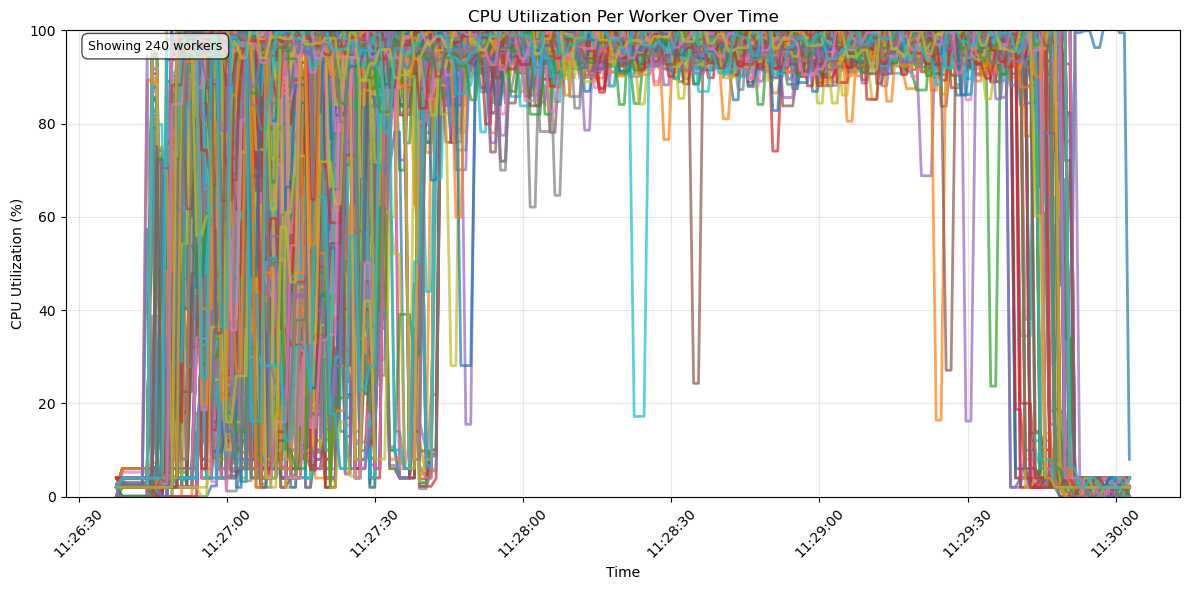

✅ CPU utilization shows actual CPU % (0-100%) per worker


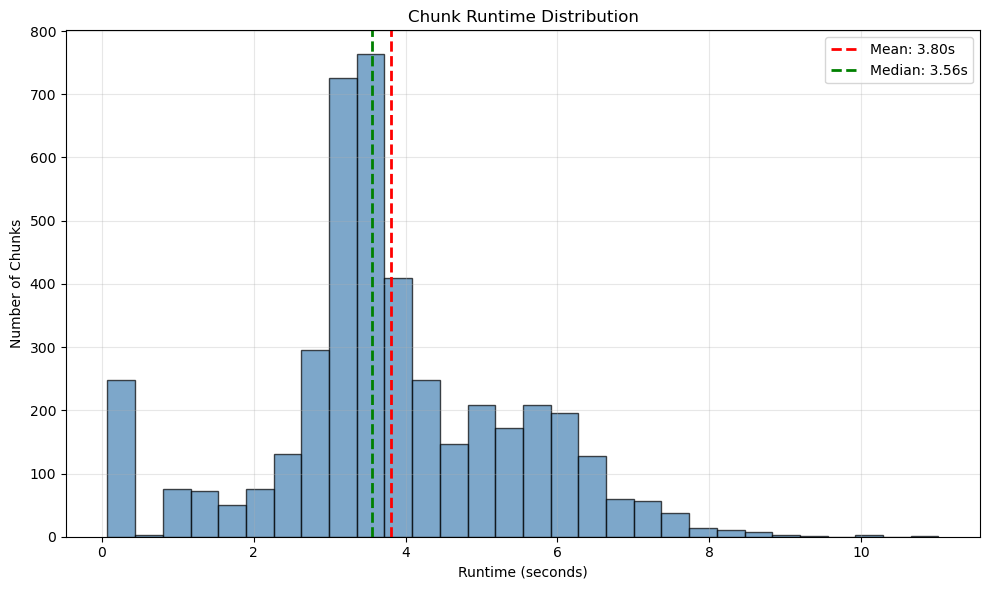

✅ Runtime distribution shows processing time variability


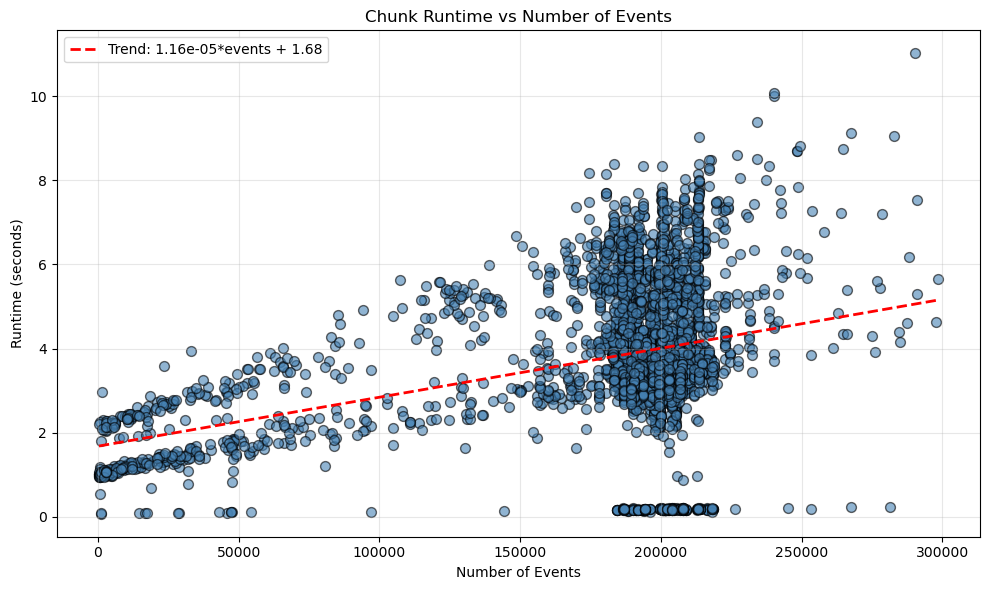

✅ Runtime vs events shows scaling behavior


In [18]:
# Plot CPU utilization timeline

print(collector.tracking_data.keys())
try:
  fig, ax = plot_cpu_utilization_timeline(collector.tracking_data)
  plt.show()
  print("✅ CPU utilization shows actual CPU % (0-100%) per worker")
except Exception as e:
  print(f"❌ CPU utilization plot unavailable: {e}")


# Plot chunk runtime distribution
try:
  fig, ax = plot_runtime_distribution(metrics.get('raw_chunk_metrics'))
  plt.show()
  print("✅ Runtime distribution shows processing time variability")
except Exception as e:
  print(f"❌ Runtime distribution unavailable: {e}")

# Plot runtime vs number of events
try:
  fig, ax = plot_runtime_vs_events(metrics.get('raw_chunk_metrics'))
  plt.show()
  print("✅ Runtime vs events shows scaling behavior")
except Exception as e:
  print(f"❌ Runtime vs events plot unavailable: {e}")